In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os import environ
from pathlib import Path
from typing import List

import torch
import pandas as pd
import numpy as np
from astropy.io import fits

from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from bliss.surveys.des import DarkEnergySurvey, DESDownloader

from pathlib import Path
from hydra import initialize, compose
from bliss.main import predict

In [3]:
environ["CUDA_VISIBLE_DEVICES"] = "6"

In [4]:
with initialize(config_path="../", version_base=None):
    cfg = compose("config", {
        "encoder.tiles_to_crop=0",
        })

In [5]:
cfg.predict

{'dataset': '${surveys.des}', 'trainer': {'_target_': 'pytorch_lightning.Trainer', 'accelerator': 'gpu', 'precision': '${train.trainer.precision}'}, 'encoder': '${encoder}', 'weight_save_path': '${paths.output}/version_1/checkpoints/best_encoder.ckpt', 'device': 'cuda:0'}

In [6]:
encoder = instantiate(cfg.predict.encoder)
enc_state_dict = torch.load(cfg.predict.weight_save_path)
enc_state_dict = enc_state_dict["state_dict"]
encoder.load_state_dict(enc_state_dict)
#dataset = instantiate(cfg.cached_simulator)
#trainer = instantiate(cfg.predict.trainer)

<All keys matched successfully>

In [33]:
def create_overlay(predictions, tile_size):
    overlay = torch.zeros((predictions.size(0) * tile_size, predictions.size(1) * tile_size, 3))
    detection_color = torch.tensor([0.0, 1.0, 0.0])  # Green color
    non_detection_color = torch.tensor([1.0, 0.0, 0.0])  # Red color
    for i in range(predictions.size(0)):
        for j in range(predictions.size(1)):
            color = detection_color if predictions[i, j] == 1 else non_detection_color
            overlay[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size] = color
    return overlay

def blend_images(original, overlay, alpha=0.5, img_crop=0):
    # Ensure the original image is in float
    if original.max() > 1.0:
        original = original / 255.0
    # Blend the images
    blended = original * (1 - alpha) + overlay * alpha
    blended = blended[img_crop: blended.size(0) - img_crop, img_crop: blended.size(1) - img_crop]
    print(blended.shape)
    return blended

def compute_metrics(est_cat, true_cat):
    true_positives = (est_cat & true_cat).sum(dtype=torch.float32)
    true_positives = (est_cat & true_cat).sum(dtype=torch.float32)
    false_positives = (est_cat & ~true_cat).sum(dtype=torch.float32)
    false_negatives = (~est_cat & true_cat).sum(dtype=torch.float32)
    true_negatives = (~est_cat & ~true_cat).sum(dtype=torch.float32)

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives + 1e-6)  # Avoid division by zero
    recall = true_positives / (true_positives + false_negatives + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    return accuracy.item(), precision.item(), recall.item(), f1.item()
    

In [41]:
DES_DIR = Path("/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0042-5457")
image_g = torch.tensor(fits.getdata(next(DES_DIR.glob("*g_nobkg.fits.fz"))))
image_r = torch.tensor(fits.getdata(next(DES_DIR.glob("*r_nobkg.fits.fz"))))
image_i = torch.tensor(fits.getdata(next(DES_DIR.glob("*i_nobkg.fits.fz"))))
image_z = torch.tensor(fits.getdata(next(DES_DIR.glob("*z_nobkg.fits.fz"))))

In [46]:
subimages_g = image_g.unfold(0, 2560, 2480).unfold(1, 2560, 2480).flatten(0,1)
subimages_r = image_r.unfold(0, 2560, 2480).unfold(1, 2560, 2480).flatten(0,1)
subimages_i = image_i.unfold(0, 2560, 2480).unfold(1, 2560, 2480).flatten(0,1)
subimages_z = image_z.unfold(0, 2560, 2480).unfold(1, 2560, 2480).flatten(0,1)

In [50]:
image_overall = torch.stack([subimages_g, subimages_r, subimages_i, subimages_z], axis=1).unsqueeze(2)
image_overall.shape

torch.Size([16, 4, 1, 2560, 2560])

In [38]:
image_full = torch.tensor(np.stack([image_g[0:5120, 0:5120], image_r[0:5120, 0:5120], image_i[0:5120, 0:5120], image_z[0:5120, 0:5120]])).unsqueeze(0).unsqueeze(2)
x = encoder.features_net(image_full)
x_cat = encoder.marginal_net(x)
marginal_cat = encoder.var_dist.sample(x_cat, use_mode=True)

torch.Size([5120, 5120, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


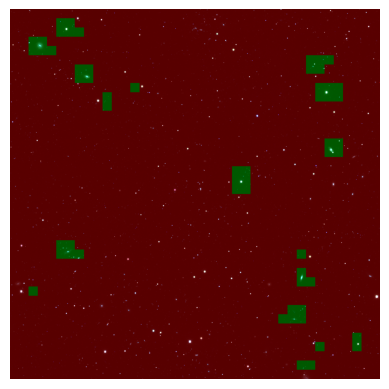

In [39]:
test_img = image_full[0,0:3,0,:,:]
test_out = marginal_cat["membership"].squeeze()
overlay = create_overlay(test_out, tile_size=128)
blended_image = blend_images(test_img.permute(1,2,0), overlay, alpha=0.35, img_crop=0)

plt.imshow(blended_image, origin="lower")
plt.axis('off')
plt.show()

In [51]:
os.listdir(DES_DIR)

['DES0042-5457_dr2_flux.fits',
 'DES0042-5457_r4907p01_i_nobkg.fits.fz',
 'DES0042-5457_r4907p01_Y_nobkg.fits.fz',
 'DES0042-5457_r4907p01_g_nobkg.fits.fz',
 'DES0042-5457_dr2_main.fits',
 'DES0042-5457_r4907p01_r_nobkg.fits.fz',
 'DES0042-5457_dr2_magnitude.fits',
 'DES0042-5457_r4907p01_z_nobkg.fits.fz']

In [60]:
main_path = DES_DIR / Path("DES0042-5457_dr2_main.fits")
flux_path = DES_DIR / Path("DES0042-5457_dr2_flux.fits")
mag_path = DES_DIR / Path("DES0042-5457_dr2_magnitude.fits")
main_data = fits.getdata(main_path)
main_df = pd.DataFrame(main_data)
main_df

,COADD_OBJECT_ID,TILENAME,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,RA,DEC,ALPHAWIN_J2000,...,SPREADERR_MODEL_G,SPREADERR_MODEL_R,SPREADERR_MODEL_I,SPREADERR_MODEL_Z,SPREADERR_MODEL_Y,WAVG_SPREADERR_MODEL_G,WAVG_SPREADERR_MODEL_R,WAVG_SPREADERR_MODEL_I,WAVG_SPREADERR_MODEL_Z,WAVG_SPREADERR_MODEL_Y
0,1093772810,DES0042-5457,8740,34963,8950706,143211308,2291380942,10.102113,-54.991700,10.102113,...,0.013615,0.013934,0.011984,0.007408,0.060836,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
1,1094174865,DES0042-5457,8740,34963,8950682,143210915,2291374654,10.102175,-55.113573,10.102175,...,0.065289,0.008580,0.009796,0.019124,0.028134,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
2,1093763817,DES0042-5457,8740,34963,8950714,143211431,2291382908,10.102210,-54.902055,10.102210,...,0.000450,0.000447,0.000652,0.001155,0.004082,0.000469,0.000407,0.000667,0.001310,0.003946
3,1093741326,DES0042-5457,8742,34969,8952091,143233467,2291735487,10.104970,-54.654636,10.104970,...,0.008624,0.012586,0.019197,0.012332,0.090124,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
4,1093767897,DES0042-5457,8740,34963,8950712,143211405,2291382488,10.102240,-54.942240,10.102240,...,0.009663,0.002969,0.002601,0.002971,0.022183,-99.000000,0.002732,0.002562,0.003890,-99.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65649,1094174808,DES0042-5457,8740,34963,8950614,143209829,2291357266,11.345093,-55.113425,11.345093,...,0.000975,0.000748,0.001086,0.001893,0.005837,0.001050,0.000686,0.001100,0.002015,0.010515
65650,1093748122,DES0042-5457,8740,34963,8950741,143211861,2291389778,11.345115,-54.729339,11.345115,...,0.001784,0.001549,0.002316,0.003115,0.016326,0.001899,0.001425,0.002301,0.003530,-99.000000
65651,1093763041,DES0042-5457,8740,34963,8950647,143210353,2291365657,11.345180,-54.891020,11.345180,...,0.011468,0.006982,0.004996,0.004875,0.019707,-99.000000,-99.000000,-99.000000,0.007050,-99.000000
65652,1093768646,DES0042-5457,8740,34963,8950645,143210320,2291365127,11.345219,-54.949379,11.345219,...,0.005978,0.004477,0.004967,0.010616,0.025553,0.006582,0.005829,0.005585,-99.000000,-99.000000


In [61]:
flux_data = fits.getdata(flux_path)
flux_df = pd.DataFrame(flux_data)
flux_df

,COADD_OBJECT_ID,TILENAME,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,RA,DEC,ALPHAWIN_J2000,...,WAVG_FLUX_PSF_G,WAVG_FLUX_PSF_R,WAVG_FLUX_PSF_I,WAVG_FLUX_PSF_Z,WAVG_FLUX_PSF_Y,WAVG_FLUXERR_PSF_G,WAVG_FLUXERR_PSF_R,WAVG_FLUXERR_PSF_I,WAVG_FLUXERR_PSF_Z,WAVG_FLUXERR_PSF_Y
0,1093734883,DES0042-5457,8742,34969,8952132,143234120,2291745924,10.635903,-54.596132,10.635903,...,inf,inf,inf,inf,inf,-inf,-inf,-inf,-inf,-inf
1,1093734884,DES0042-5457,8740,34963,8950751,143212017,2291392279,11.269028,-54.599886,11.269028,...,inf,inf,inf,inf,inf,-inf,-inf,-inf,-inf,-inf
2,1093734885,DES0042-5457,8740,34963,8950750,143212013,2291392212,11.200232,-54.607477,11.200232,...,inf,528.339722,3100.220703,6366.391113,8011.937500,-inf,23.420773,37.640095,70.123100,290.813934
3,1093734911,DES0042-5457,8740,34963,8950772,143212353,2291397654,11.140822,-54.607379,11.140822,...,727.736633,1534.943481,1905.700195,2097.547363,3540.754883,18.609550,22.558342,36.101875,68.389847,393.937042
4,1093734921,DES0042-5457,8740,34963,8950751,143212018,2291392298,11.214922,-54.603998,11.214922,...,1615.150879,2800.713867,3146.999512,3559.421631,3878.755615,17.618483,22.759192,38.033901,71.511101,328.798676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65649,1094192931,DES0042-5457,8740,34961,8950266,143204265,2291268240,11.105713,-55.309483,11.105713,...,inf,inf,inf,inf,inf,-inf,-inf,-inf,-inf,-inf
65650,1094192932,DES0042-5457,8740,34961,8950265,143204246,2291267936,11.256300,-55.308939,11.256300,...,216.968140,inf,inf,inf,inf,33.516602,-inf,-inf,-inf,-inf
65651,1094192939,DES0042-5457,8740,34961,8950266,143204259,2291268150,11.124007,-55.309518,11.124007,...,inf,inf,inf,inf,inf,-inf,-inf,-inf,-inf,-inf
65652,1094192940,DES0042-5457,8740,34961,8950265,143204245,2291267920,11.289284,-55.308921,11.289284,...,inf,inf,inf,inf,inf,-inf,-inf,-inf,-inf,-inf


In [62]:
mag_data = fits.getdata(mag_path)
mag_df = pd.DataFrame(mag_data)
mag_df

,COADD_OBJECT_ID,TILENAME,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,RA,DEC,ALPHAWIN_J2000,...,WAVG_MAG_PSF_G,WAVG_MAG_PSF_R,WAVG_MAG_PSF_I,WAVG_MAG_PSF_Z,WAVG_MAG_PSF_Y,WAVG_MAGERR_PSF_G,WAVG_MAGERR_PSF_R,WAVG_MAGERR_PSF_I,WAVG_MAGERR_PSF_Z,WAVG_MAGERR_PSF_Y
0,1093734883,DES0042-5457,8742,34969,8952132,143234120,2291745924,10.635903,-54.596132,10.635903,...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
1,1093734884,DES0042-5457,8740,34963,8950751,143212017,2291392279,11.269028,-54.599886,11.269028,...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
2,1093734885,DES0042-5457,8740,34963,8950750,143212013,2291392212,11.200232,-54.607477,11.200232,...,-99.000000,23.192717,21.271519,20.490267,20.240656,-99.000000,0.048128,0.013182,0.011959,0.039408
3,1093734888,DES0042-5457,8742,34969,8952093,143233502,2291736035,10.340734,-54.606577,10.340734,...,22.408525,21.120655,20.626757,20.351274,20.196964,0.024120,0.010026,0.011602,0.012624,0.047504
4,1093734891,DES0042-5457,8740,34963,8950769,143212311,2291396991,11.095206,-54.605877,11.095206,...,22.901011,21.082960,20.475447,20.201565,19.958654,0.027369,0.006524,0.006624,0.008468,0.028235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65649,1094193024,DES0042-5457,8740,34961,8950262,143204200,2291267205,11.341446,-55.309646,11.341446,...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
65650,1094192940,DES0042-5457,8740,34961,8950265,143204245,2291267920,11.289284,-55.308921,11.289284,...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
65651,1094192924,DES0042-5457,8740,34963,8950597,143209556,2291352901,11.041695,-55.309637,11.041695,...,24.062397,23.925962,23.055971,22.701756,-99.000000,0.217302,0.099307,0.066395,0.126806,-99.000000
65652,1094192931,DES0042-5457,8740,34961,8950266,143204265,2291268240,11.105713,-55.309483,11.105713,...,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
